**Importing Libraries**

In [11]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
#from PIL import Image

**Setting constants**

In [12]:
IMG_SIZE = 1024
BATCH_SIZE = 10
CHANNELS = 3
EPOCHS = 100

**Loading data into tensorflow dataset object**

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
)

# Getting the class names
class_names = dataset.class_names
class_names

Found 208 files belonging to 4 classes.


['-K', '-N', '-P', 'FN']

**Visualizing some of the images**

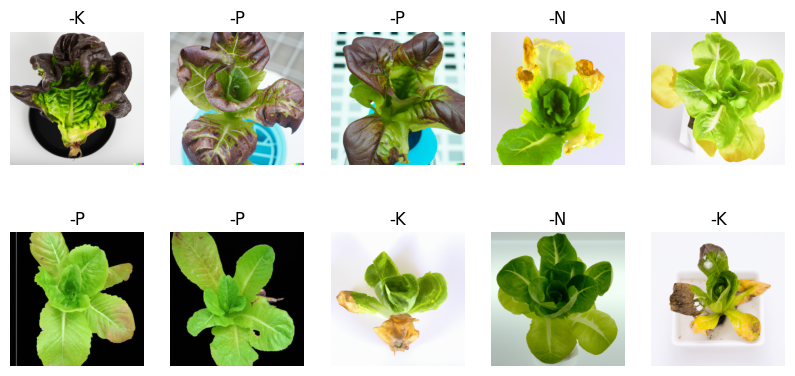

In [28]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

**Constants for data splitting**

In [15]:
dataset_size = len(dataset)       # 21 (number of pictures/batch_size)
train_size = 0.8                  # training = 10%
val_size = 0.1                    # validation = 10%
test_size = 0.1                   # test = 10%

**Function for data splitting**

In [27]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
  
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_data = ds.take(train_size)    
    val_data = ds.skip(train_size).take(val_size)
    test_data = ds.skip(train_size).skip(val_size)

    return train_data, val_data, test_data

**Data Splitting**

In [17]:
train_data, val_data, test_data = split_dataset(dataset)
len(train_data), len(val_data), len(test_data)

(16, 2, 3)

**Cache, Shuffle, and Prefetch**\
Cache - cache the dataset in memory\
Shuffle - shuffle the images\
Prefetch - overlaps the preprocessing and model execution of a training step\
This is to reduce memory usage and optimize the pipeline performance.
https://www.tensorflow.org/guide/data_performance

In [18]:
train_data = train_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

**Resizing and Normalization** \
Since majority of the images in the dataset are in the size 1024x1024, in this layer the images will be resized to the desired size 1024x1024. The image pixel value will be normalized or rescaled to a range from 0 to 1. This is to improve model performance.\
https://stackoverflow.com/questions/66971140/what-rescaling-actually-does-in-tensorflow \
https://www.tensorflow.org/guide/data_performance

In [23]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1.0/255),
]) #layers.experimental.preprocessing.Resizing

**Data Augmentation**

In [30]:
data_augmentation = tf.keras.Sequential([
    #layers.RandomCrop(1000,1000)
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', fill_value=0.0),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])